In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import RetinaDataset
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
import torch

import harmonypy

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

In [2]:
def getNClusters(data, n_cluster, range_min=0, range_max=4, max_steps=20, verbose=False):
    if isinstance(data, np.ndarray):
        data = anndata.AnnData(X=data)
    assert isinstance(data, anndata.AnnData), \
        "data must be numpy.ndarray or anndata.AnnData"
    this_min = range_min
    this_max = range_max
    for this_step in range(max_steps):
        if verbose:
            print("step: " + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.pp.neighbors(data)
        sc.tl.louvain(data, resolution=this_resolution)
        this_clusters = len(np.unique(data.obs['louvain']))
        if verbose:
            print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        if this_clusters > n_cluster:
            this_max = this_resolution
        if this_clusters < n_cluster:
            this_min = this_resolution
        if this_clusters == n_cluster:
            if not verbose:
                print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
            return data
    print('Cannot find the number of clusters')

In [3]:
from scipy.optimize import linear_sum_assignment
def align(y_true, y_pred, index):
    y_true = pd.Categorical(y_true)
    y_types = y_true.categories.tolist()
    y_label = y_true.codes
    y_label = np.array(y_label) if type(y_label) != np.ndarray else y_label
    y_pred = np.array(y_pred) if type(y_pred) != np.ndarray else y_pred
    y_label = y_label.astype(np.int64)
    D = max(y_pred.max(), y_label.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_label[i]] += 1
    ind = linear_sum_assignment(w.max() - w)[1]
    y_pred = ind[y_pred]
    labels_pred=pd.Series(y_pred, index = index, dtype='category')
    labels_pred.cat.categories=list(range(len(np.unique(y_pred))))
    return labels_pred

In [4]:
save_path = "/data/Bear/scVIC/notebooks/Datasets/Biological Datasets"
retina_dataset = RetinaDataset(save_path=save_path)
retina_dataset.filter_genes_by_count(per_batch=True)
retina_dataset.make_gene_names_lower()
retina_dataset.subsample_genes(4000)

[2024-05-06 22:20:53,667] INFO - scvi.dataset.dataset | File /data/Bear/scVIC/notebooks/Datasets/Biological Datasets/retina.loom already downloaded
[2024-05-06 22:20:53,669] INFO - scvi.dataset.loom | Preprocessing dataset
[2024-05-06 22:21:03,038] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2024-05-06 22:21:07,540] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2024-05-06 22:21:07,543] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2024-05-06 22:21:08,031] INFO - scvi.dataset.dataset | Downsampling from 13166 to 13085 genes
[2024-05-06 22:21:11,542] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2024-05-06 22:21:12,770] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2024-05-06 22:21:16,420] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2024-05-06 22:21:16,786] INFO - scvi.dataset.dataset | Downsampled from 19829 to 19829 cells
[2024-05-06 22:21:16,787] INFO - scvi.dataset

In [5]:
adata_harmony = anndata.AnnData(X=retina_dataset.X)
adata_harmony.obs["Harmony"] = [str(i[0]) for i in retina_dataset.batch_indices]
sc.pp.scale(adata_harmony)
sc.tl.pca(adata_harmony, n_comps=30)

In [6]:
harmony_out = harmonypy.run_harmony(adata_harmony.obsm["X_pca"], adata_harmony.obs, "Harmony")
adata_harmony.obsm["X_pca_harmony"] = harmony_out.Z_corr.T

2024-05-06 22:21:36,594 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-06 22:21:51,233 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-06 22:21:51,510 - harmonypy - INFO - Iteration 1 of 10
2024-05-06 22:21:59,104 - harmonypy - INFO - Iteration 2 of 10
2024-05-06 22:22:06,729 - harmonypy - INFO - Iteration 3 of 10
2024-05-06 22:22:14,310 - harmonypy - INFO - Iteration 4 of 10
2024-05-06 22:22:21,925 - harmonypy - INFO - Iteration 5 of 10
2024-05-06 22:22:29,521 - harmonypy - INFO - Iteration 6 of 10
2024-05-06 22:22:37,119 - harmonypy - INFO - Iteration 7 of 10
2024-05-06 22:22:40,859 - harmonypy - INFO - Converged after 7 iterations


In [7]:
data = getNClusters(adata_harmony.obsm["X_pca_harmony"], n_cluster=retina_dataset.n_labels)
labels_pred = data.obs["louvain"].astype(int)

got 15 at resolution 0.640625


In [8]:
post_adata = anndata.AnnData(X=retina_dataset.X)
post_adata.obsm["X_harmony"] = adata_harmony.obsm["X_pca_harmony"]
post_adata.obs['cell_type'] = np.array([retina_dataset.cell_types[retina_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([str(retina_dataset.batch_indices[i][0])
                                   for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels_pred, index=post_adata.obs.index, dtype='category')
labels_pred.cat.categories=list(range(len(labels_pred.unique())))
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_harmony", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

... storing 'cell_type' as categorical
... storing 'batch' as categorical


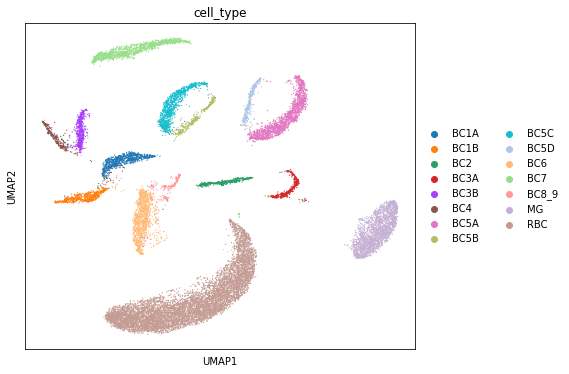

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot, save="/RETINA_Harmony_Louvain_cell_type.png")

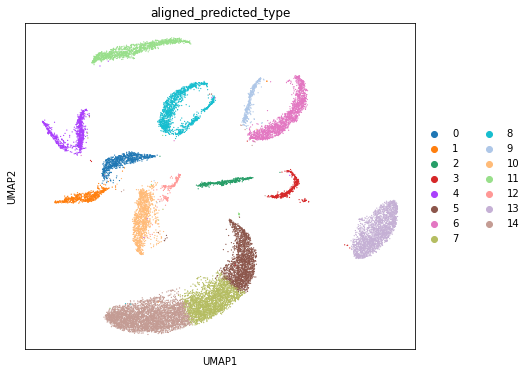

In [10]:
post_adata.obs["aligned_predicted_type"] = align(post_adata.obs["cell_type"], post_adata.obs["predicted_type"], index=post_adata.obs.index)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["aligned_predicted_type"], ax=ax, show=show_plot, save="/RETINA_Harmony_Louvain_predicted_type.png")

In [11]:
ARI = np.around(adjusted_rand_score(retina_dataset.labels.squeeze(), labels_pred), 5)
print("RETINA_harmony_Louvain_ARI: ")
print(ARI)
NMI = np.around(normalized_mutual_info_score(retina_dataset.labels.squeeze(), labels_pred, average_method='arithmetic'), 5)
print("RETINA_harmony_Louvain_NMI: ")
print(NMI)  

RETINA_harmony_Louvain_ARI: 
0.57234
RETINA_harmony_Louvain_NMI: 
0.85776


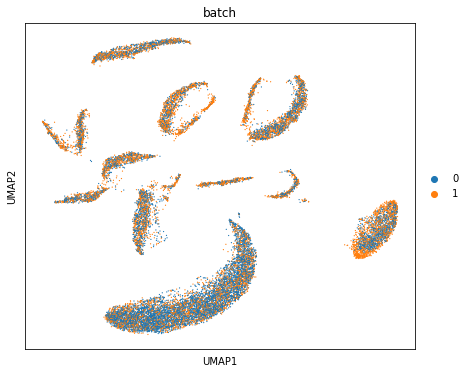

In [12]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot, save="/RETINA_Harmony_Louvain_batch.png")

In [13]:
from scvic.utils import entropy_batch_mixing
entropy_batch_mixing = np.around(entropy_batch_mixing(adata_harmony.obsm["X_pca_harmony"], retina_dataset.batch_indices, retina_dataset.n_batches), 5)
print("RETINA_harmony_batch_mixing: ") 
print(entropy_batch_mixing)

RETINA_harmony_batch_mixing: 
0.07634
